In [2]:
import os
import numpy as np
import random
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Define paths
gan_healthy_dir = '/kaggle/input/healthy-gan'
gan_tumour_dir = '/kaggle/input/tumour-gan'
test_dir = '/kaggle/input/test-dataset'

train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'

os.makedirs(os.path.join(train_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'tumour'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'tumour'), exist_ok=True)

# Split function: move files into train/val folders
def split_data(src_folder, train_class_dir, val_class_dir, split_ratio=0.8):
    filenames = os.listdir(src_folder)
    random.shuffle(filenames)
    split_idx = int(len(filenames) * split_ratio)
    train_files = filenames[:split_idx]
    val_files = filenames[split_idx:]
    
    for fname in train_files:
        copyfile(os.path.join(src_folder, fname), os.path.join(train_class_dir, fname))
        
    for fname in val_files:
        copyfile(os.path.join(src_folder, fname), os.path.join(val_class_dir, fname))

# Move GAN files into structured directories
split_data(gan_healthy_dir, os.path.join(train_dir, 'healthy'), os.path.join(val_dir, 'healthy'))
split_data(gan_tumour_dir, os.path.join(train_dir, 'tumour'), os.path.join(val_dir, 'tumour'))

In [3]:
img_size = (128, 128)
batch_size = 32

# Only rescaling
datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

# Validation generator
val_generator = datagen_val.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

# Test generator
test_generator = datagen_test.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 956 images belonging to 2 classes.
Found 356 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
import os
from shutil import rmtree

# Remove previous train/val folders to start fresh
if os.path.exists('/kaggle/working/train'):
    rmtree('/kaggle/working/train')
if os.path.exists('/kaggle/working/val'):
    rmtree('/kaggle/working/val')

# Recreate directories
os.makedirs('/kaggle/working/train/healthy', exist_ok=True)
os.makedirs('/kaggle/working/train/tumour', exist_ok=True)
os.makedirs('/kaggle/working/val/healthy', exist_ok=True)
os.makedirs('/kaggle/working/val/tumour', exist_ok=True)

In [5]:
import random
from shutil import copyfile

def copy_fixed_split(src_folder, train_folder, val_folder, num_train=400, num_val=100):
    all_files = os.listdir(src_folder)
    random.shuffle(all_files)
    
    # Pick exact number of train and val files
    train_files = all_files[:num_train]
    val_files = all_files[num_train:num_train + num_val]
    
    for fname in train_files:
        copyfile(os.path.join(src_folder, fname), os.path.join(train_folder, fname))
        
    for fname in val_files:
        copyfile(os.path.join(src_folder, fname), os.path.join(val_folder, fname))

# Copy exactly 400 train + 100 val from each class
copy_fixed_split('/kaggle/input/healthy-gan', '/kaggle/working/train/healthy', '/kaggle/working/val/healthy', 400, 100)
copy_fixed_split('/kaggle/input/tumour-gan', '/kaggle/working/train/tumour', '/kaggle/working/val/tumour', 400, 100)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    '/kaggle/working/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

val_generator = datagen_val.flow_from_directory(
    '/kaggle/working/val',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

test_generator = datagen_test.flow_from_directory(
    '/kaggle/input/test-dataset',
    target_size=img_size,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750002026.059801      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750002026.060540      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1750002038.049652     143 service.cc:148] XLA service 0x7b2970005370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750002038.050572     143 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750002038.050598     143 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750002038.402125     143 cuda_dnn.cc:529] Loaded cuDNN version 90300


 7/25 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5657 - loss: 0.6529

I0000 00:00:1750002041.840728     143 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.7178 - loss: 0.4843 - val_accuracy: 1.0000 - val_loss: 0.0165
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 1.0000 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 5.7717e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 1.0000 - loss: 9.0695e-04 - val_accuracy: 1.0000 - val_loss: 2.5776e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 1.0000 - loss: 4.1243e-04 - val_accuracy: 1.0000 - val_loss: 7.2969e-05
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 1.0000 - loss: 8.3176e-05 - val_accuracy: 1.0000 - val_loss: 5.7828e-05
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 1.6033e-05 - val_accuracy: 1.0000 - val_loss: 3.4495e-05
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 1.0000 - loss: 7.3574e-05 - val_accuracy: 1.0000 - val_loss: 2.3291e-05
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 

# All Gan 1000:0

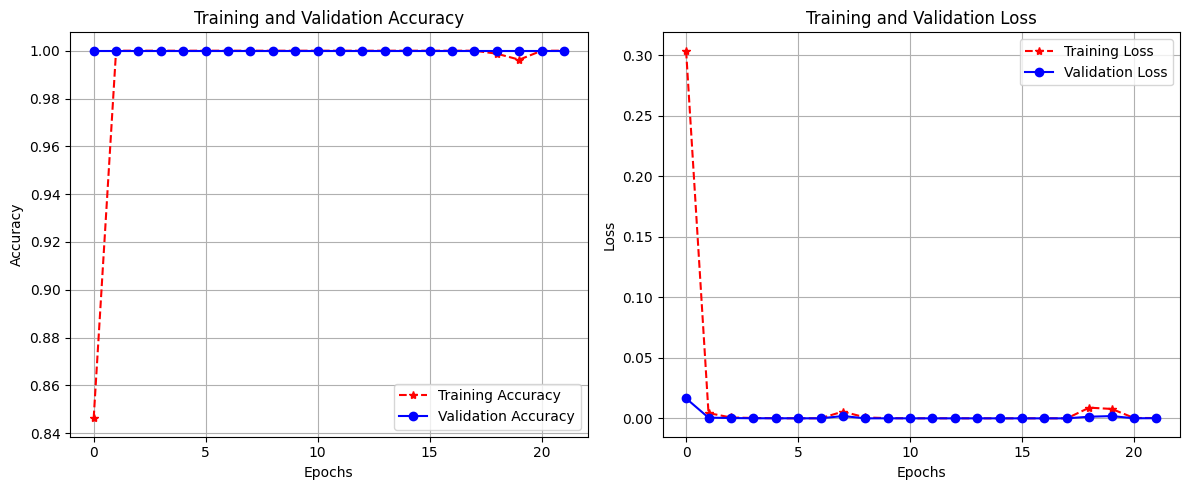

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '*--', color='red', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'o-', color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, '*--', color='red', label='Training Loss')
plt.plot(epochs_range, val_loss, 'o-', color='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Save to working directory
plt.savefig('/kaggle/working/training_validation_curve.png')

# Show plot
plt.show()

In [11]:
test_generator.reset()
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int)
y_true = test_generator.classes

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
Accuracy: 0.654
Precision: 0.7305389221556886
Recall: 0.488
F1 Score: 0.5851318944844125

Classification Report:
              precision    recall  f1-score   support

     healthy       0.62      0.82      0.70       500
      tumour       0.73      0.49      0.59       500

    accuracy                           0.65      1000
   macro avg       0.67      0.65      0.64      1000
weighted avg       0.67      0.65      0.64      1000



In [12]:
test_generator.reset()
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int)
y_true = test_generator.classes
y_scores = preds.flatten()  # Probability scores for ROC

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


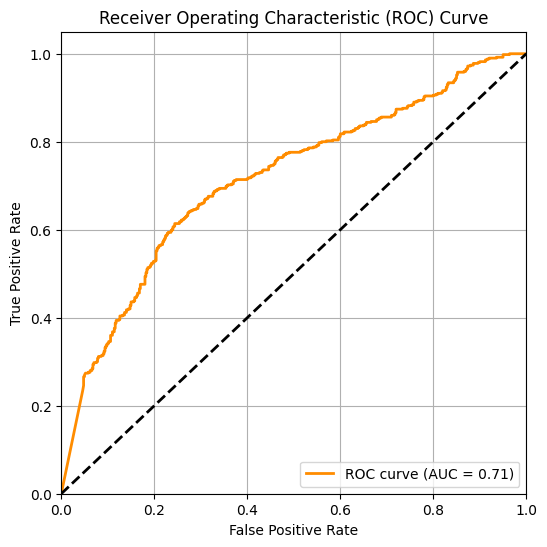

In [13]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('/kaggle/working/roc_curve.png')
plt.show()

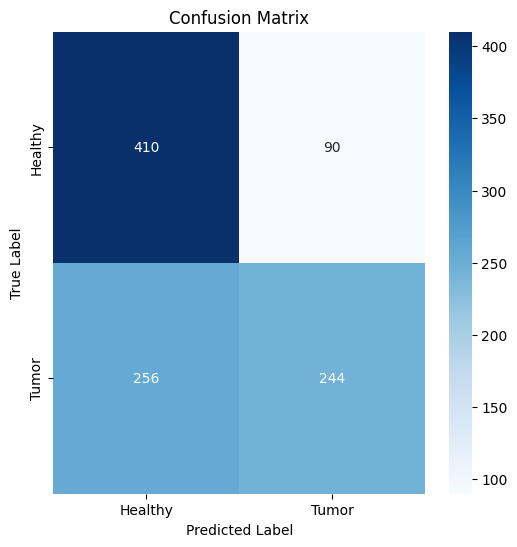

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
class_names = ['Healthy', 'Tumor']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# CNN for all

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_cnn_model(img_size=(128, 128)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Data splitting helper

In [16]:
import os
from shutil import copyfile
import random

def prepare_data_dirs(base_yes_dir, base_no_dir, working_dir, train_ratio=0.8):
    # Clear previous data if any
    train_dir = os.path.join(working_dir, 'train')
    val_dir = os.path.join(working_dir, 'val')

    for path in [train_dir, val_dir]:
        if os.path.exists(path):
            import shutil
            shutil.rmtree(path)
        os.makedirs(os.path.join(train_dir, 'yes'), exist_ok=True)
        os.makedirs(os.path.join(train_dir, 'no'), exist_ok=True)
        os.makedirs(os.path.join(val_dir, 'yes'), exist_ok=True)
        os.makedirs(os.path.join(val_dir, 'no'), exist_ok=True)

    # Get all files
    yes_files = os.listdir(base_yes_dir)
    no_files = os.listdir(base_no_dir)

    random.shuffle(yes_files)
    random.shuffle(no_files)

    train_yes = yes_files[:int(len(yes_files) * train_ratio)]
    val_yes = yes_files[int(len(yes_files) * train_ratio):]

    train_no = no_files[:int(len(no_files) * train_ratio)]
    val_no = no_files[int(len(no_files) * train_ratio):]

    # Copy files
    def copy_files(files, src, dst):
        for f in files:
            copyfile(os.path.join(src, f), os.path.join(dst, f))

    copy_files(train_yes, base_yes_dir, os.path.join(train_dir, 'yes'))
    copy_files(val_yes, base_yes_dir, os.path.join(val_dir, 'yes'))
    copy_files(train_no, base_no_dir, os.path.join(train_dir, 'no'))
    copy_files(val_no, base_no_dir, os.path.join(val_dir, 'no'))

    return train_dir, val_dir

# Data Generator Setup

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_generators(train_dir, val_dir, img_size=(128, 128), batch_size=32):
    datagen_train = ImageDataGenerator(rescale=1./255)
    datagen_val = ImageDataGenerator(rescale=1./255)
    datagen_test = ImageDataGenerator(rescale=1./255)

    train_gen = datagen_train.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        seed=42
    )

    val_gen = datagen_val.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False,
        seed=42
    )

    test_gen = datagen_test.flow_from_directory(
        '/kaggle/input/brain-tumor-detection',
        target_size=img_size,
        batch_size=1,
        class_mode='binary',
        shuffle=False
    )

    return train_gen, val_gen, test_gen

# Evaluation & Visualization Functions

# Plot Training Curves

In [18]:
import matplotlib.pyplot as plt

def plot_training(history, save_path=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, '*--', color='red', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'o-', color='blue', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, '*--', color='red', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'o-', color='blue', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Plot ROC Curve

In [19]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, save_path=None):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Confusion Matrix

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Healthy', 'Tumor']

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    if save_path:
        plt.savefig(save_path)
    plt.show()

# All real 0:1000

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.6556 - loss: 0.6040 - val_accuracy: 0.7750 - val_loss: 0.4502
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8231 - loss: 0.4240 - val_accuracy: 0.8400 - val_loss: 0.3832
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8616 - loss: 0.3484 - val_accuracy: 0.8650 - val_loss: 0.3216
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8703 - loss: 0.3224 - val_accuracy: 0.8900 - val_loss: 0.3085
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9166 - loss: 0.2061 - val_accuracy: 0.9400 - val_loss: 0.2394
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9308 - loss: 0.1737 - val_accuracy: 0.9400 - val_loss: 0.1833
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9715 - loss: 0.1101 - val_accuracy: 0.9200 - val_loss: 0.1947
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9658 - loss: 0.1085 - val_accuracy: 0.9200 - val_loss: 0.

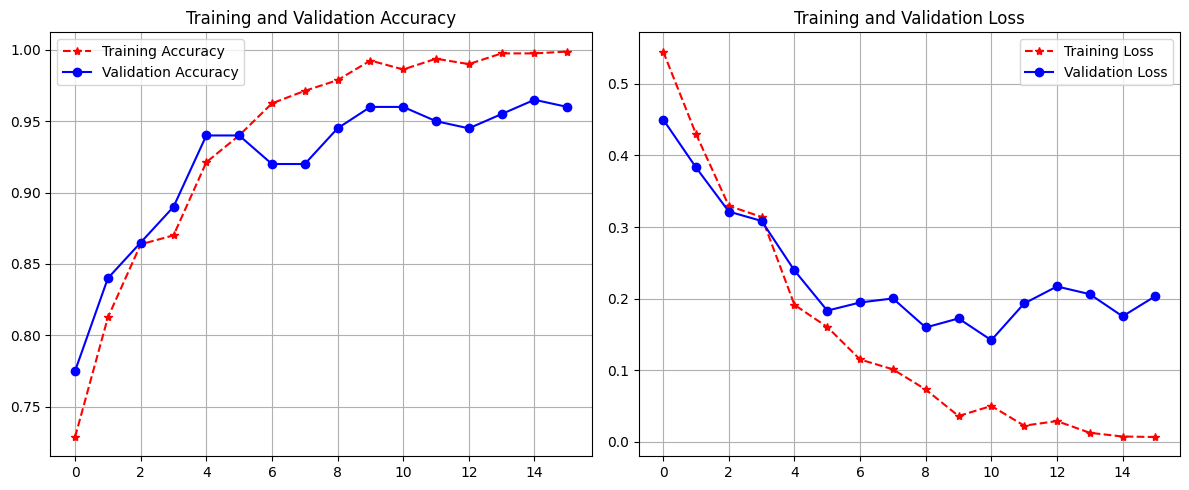

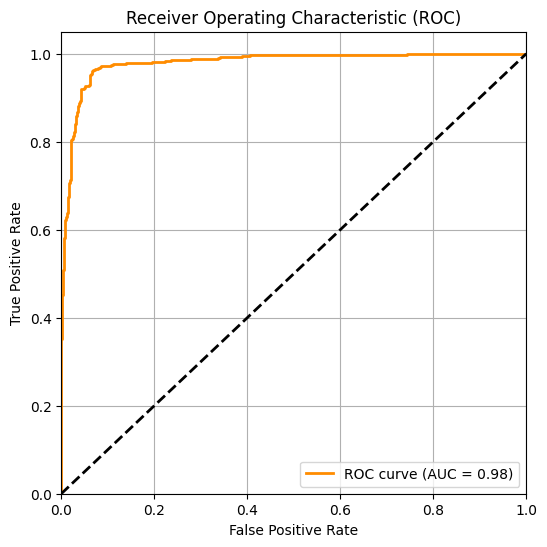

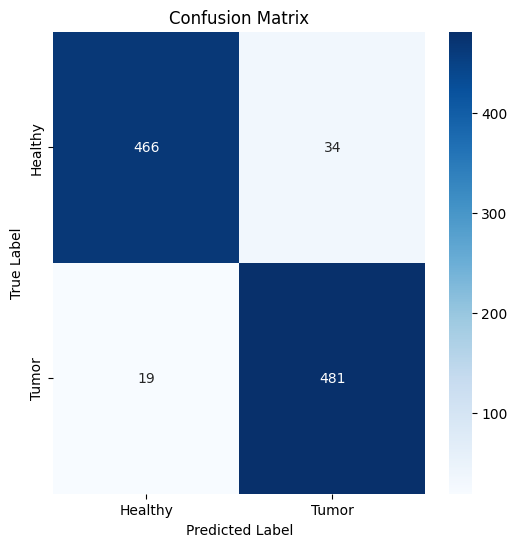

In [65]:
import os
import numpy as np
import random
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
real_healthy_dir = '/kaggle/input/brain-tumor-detection/no'
real_tumor_dir = '/kaggle/input/brain-tumor-detection/yes'

test_data_dir = '/kaggle/input/test-dataset'

# Working directories
combined_train_dir = '/kaggle/working/combined_train'
combined_val_dir = '/kaggle/working/combined_val'

os.makedirs(combined_train_dir, exist_ok=True)
os.makedirs(combined_val_dir, exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'tumour'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'tumour'), exist_ok=True)

# Helper function to copy N files from src to dst
def copy_n_files(src, dst, n=100):
    files = os.listdir(src)
    selected = random.sample(files, min(n, len(files)))
    for fname in selected:
        copyfile(os.path.join(src, fname), os.path.join(dst, fname))

# Clear previous data
for path in [combined_train_dir, combined_val_dir]:
    for cls in ['healthy', 'tumour']:
        folder = os.path.join(path, cls)
        if os.path.exists(folder):
            import shutil
            shutil.rmtree(folder)
        os.makedirs(folder)

# Copy training images (only real)
copy_n_files(real_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 400)
copy_n_files(real_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 400)

# Copy validation images (only real)
copy_n_files(real_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 100)
copy_n_files(real_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 100)

# Data generators
img_size = (128, 128)
batch_size = 32

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    combined_train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

val_generator = datagen_val.flow_from_directory(
    combined_val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

test_generator = datagen_test.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Build CNN model (same as before)
def build_cnn_model():
    return Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

model = build_cnn_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

# Evaluate on test set
test_generator.reset()
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int)
y_true = test_generator.classes
y_scores = preds.flatten()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Plot Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '*--', color='red', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'o-', color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, '*--', color='red', label='Training Loss')
plt.plot(epochs_range, val_loss, 'o-', color='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curve.png')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('/kaggle/working/roc_curve.png')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Healthy', 'Tumor']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

In [64]:
import os
import shutil

# Define the working directory (for Kaggle/Colab)
WORKING_DIR = '/kaggle/working'

# Remove all contents of the working directory
def clear_working_directory(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
            print(f"🗑️ Deleted: {file_path}")
        except Exception as e:
            print(f"❌ Failed to delete {file_path}. Reason: {e}")

# Run cleanup
clear_working_directory(WORKING_DIR)

print("✅ Working directory cleaned.")

🗑️ Deleted: /kaggle/working/combined_val
🗑️ Deleted: /kaggle/working/roc_curve.png
🗑️ Deleted: /kaggle/working/combined_train
🗑️ Deleted: /kaggle/working/confusion_matrix.png
🗑️ Deleted: /kaggle/working/training_validation_curve.png
✅ Working directory cleaned.


Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.6213 - loss: 0.6924 - val_accuracy: 0.7500 - val_loss: 0.5058
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7897 - loss: 0.4733 - val_accuracy: 0.8150 - val_loss: 0.4538
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8470 - loss: 0.3889 - val_accuracy: 0.8450 - val_loss: 0.4154
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8671 - loss: 0.3348 - val_accuracy: 0.8450 - val_loss: 0.3424
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9052 - loss: 0.2448 - val_accuracy: 0.8650 - val_loss: 0.3104
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9133 - loss: 0.2063 - val_accuracy: 0.8600 - val_loss: 0.3083
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9518 - loss: 0.1771 - val_accuracy: 0.8900 - val_loss: 0.2402
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9609 - loss: 0.1064 - val_accuracy: 0.9050 - val_loss: 0.

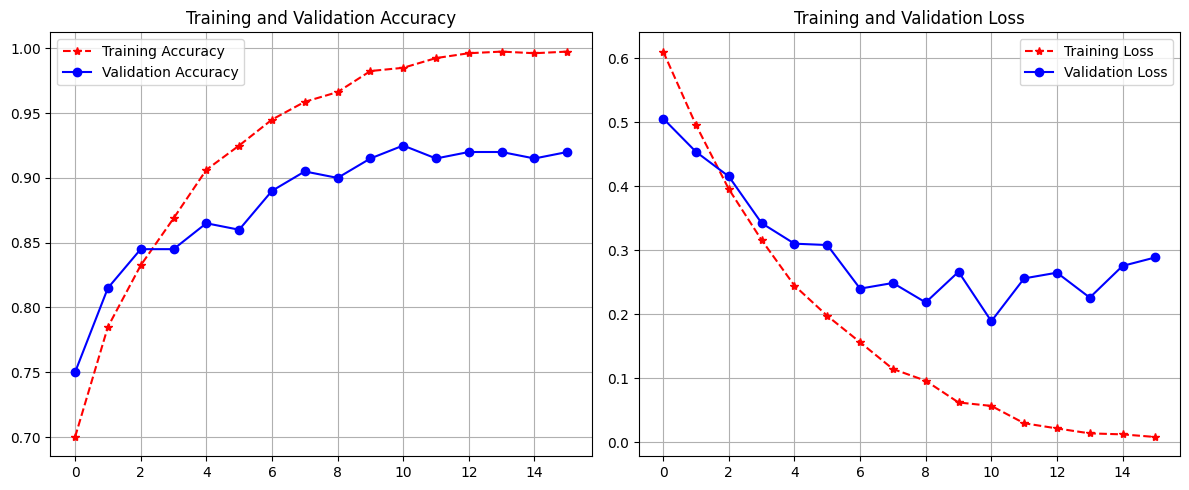

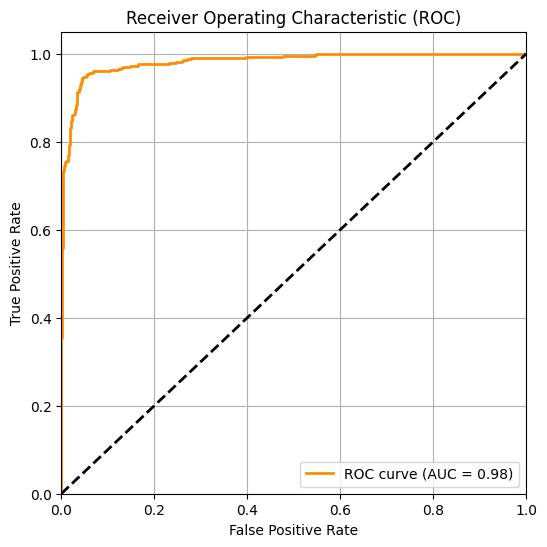

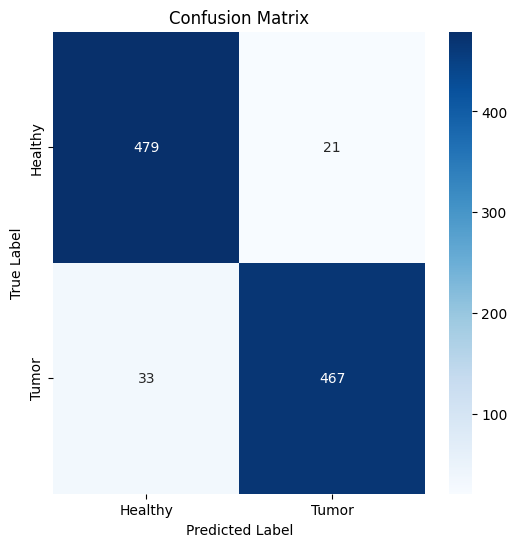

In [25]:
import os
import numpy as np
import random
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
input_yes_dir = '/kaggle/input/brain-tumor-detection/yes'
input_no_dir = '/kaggle/input/brain-tumor-detection/no'

test_dir = '/kaggle/input/test-dataset'

train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(os.path.join(train_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'tumour'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'tumour'), exist_ok=True)

# Function to copy exactly N files
def copy_n_files(src_folder, dst_folder, n=500):
    all_files = os.listdir(src_folder)
    selected_files = random.sample(all_files, n)
    for fname in selected_files:
        copyfile(os.path.join(src_folder, fname), os.path.join(dst_folder, fname))

# Copy 500 from each class for training and validation
# We'll use 400 train / 100 val per class
def split_and_copy(src_folder, train_folder, val_folder, train_count=400, val_count=100):
    all_files = os.listdir(src_folder)
    random.shuffle(all_files)
    for fname in all_files[:train_count]:
        copyfile(os.path.join(src_folder, fname), os.path.join(train_folder, fname))
    for fname in all_files[train_count:train_count+val_count]:
        copyfile(os.path.join(src_folder, fname), os.path.join(val_folder, fname))

# Clear old data if any
for path in [train_dir, val_dir]:
    if os.path.exists(path):
        import shutil
        shutil.rmtree(path)
    os.makedirs(os.path.join(path, 'healthy'), exist_ok=True)
    os.makedirs(os.path.join(path, 'tumour'), exist_ok=True)

# Copy 400 train + 100 val from each class
split_and_copy(input_yes_dir, os.path.join(train_dir, 'tumour'), os.path.join(val_dir, 'tumour'), 400, 100)
split_and_copy(input_no_dir, os.path.join(train_dir, 'healthy'), os.path.join(val_dir, 'healthy'), 400, 100)

# Data generators
img_size = (128, 128)
batch_size = 32

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

val_generator = datagen_val.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

test_generator = datagen_test.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Build CNN model
def build_cnn_model(img_size=(128, 128)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_cnn_model()

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

# Evaluate on test set
test_generator.reset()
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int)
y_true = test_generator.classes
y_scores = preds.flatten()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Plot training curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '*--', color='red', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'o-', color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, '*--', color='red', label='Training Loss')
plt.plot(epochs_range, val_loss, 'o-', color='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curve.png')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('/kaggle/working/roc_curve.png')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Healthy', 'Tumor']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# 500 GAN and 500 Real

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.6174 - loss: 0.6552 - val_accuracy: 0.8050 - val_loss: 0.4323
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8039 - loss: 0.4493 - val_accuracy: 0.8800 - val_loss: 0.3081
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8974 - loss: 0.2925 - val_accuracy: 0.9200 - val_loss: 0.2512
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9243 - loss: 0.2091 - val_accuracy: 0.9100 - val_loss: 0.2114
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9350 - loss: 0.1538 - val_accuracy: 0.9150 - val_loss: 0.1822
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9578 - loss: 0.1156 - val_accuracy: 0.9400 - val_loss: 0.1759
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9777 - loss: 0.0844 - val_accuracy: 0.9400 - val_loss: 0.2058
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9787 - loss: 0.0599 - val_accuracy: 0.9300 - val_loss: 0.

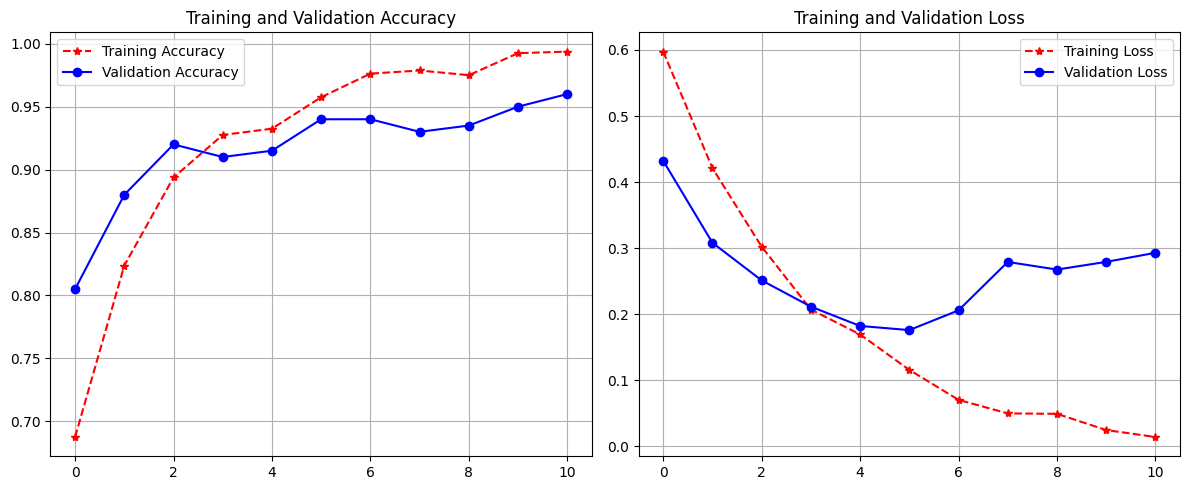

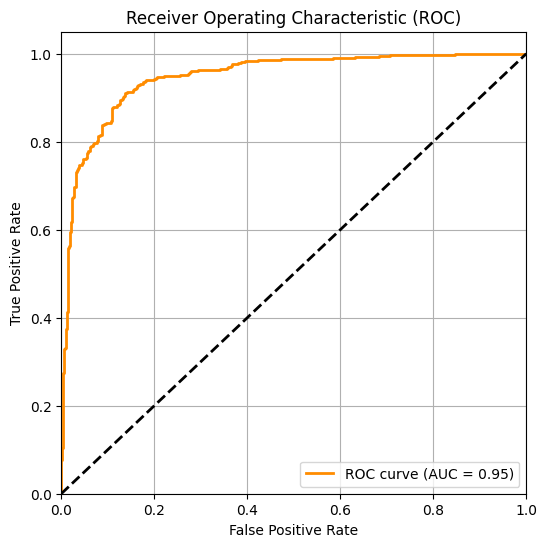

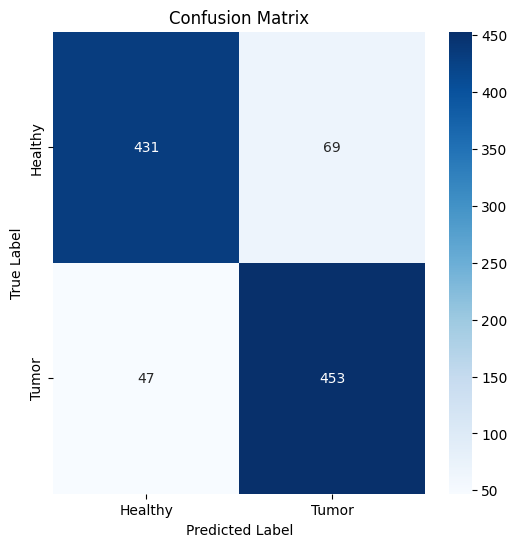

In [63]:
import os
import numpy as np
import random
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
real_healthy_dir = '/kaggle/input/brain-tumor-detection/no'
real_tumor_dir = '/kaggle/input/brain-tumor-detection/yes'

gan_healthy_dir = '/kaggle/input/healthy-gan'
gan_tumor_dir = '/kaggle/input/tumour-gan'

test_data_dir = '/kaggle/input/test-dataset'

# Working directories
combined_train_dir = '/kaggle/working/combined_train'
combined_val_dir = '/kaggle/working/combined_val'

os.makedirs(combined_train_dir, exist_ok=True)
os.makedirs(combined_val_dir, exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'tumour'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'tumour'), exist_ok=True)

# Helper function to copy N files from src to dst
def copy_n_files(src, dst, n=100):
    files = os.listdir(src)
    selected = random.sample(files, min(n, len(files)))
    for fname in selected:
        copyfile(os.path.join(src, fname), os.path.join(dst, fname))

# Clear previous data
for path in [combined_train_dir, combined_val_dir]:
    for cls in ['healthy', 'tumour']:
        folder = os.path.join(path, cls)
        if os.path.exists(folder):
            import shutil
            shutil.rmtree(folder)
        os.makedirs(folder)

# Copy training images
copy_n_files(real_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 200)
copy_n_files(real_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 200)

copy_n_files(gan_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 200)
copy_n_files(gan_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 200)

# Copy validation images
copy_n_files(real_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 50)
copy_n_files(real_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 50)

copy_n_files(gan_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 50)
copy_n_files(gan_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 50)

# Data generators
img_size = (128, 128)
batch_size = 32

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    combined_train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

val_generator = datagen_val.flow_from_directory(
    combined_val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

test_generator = datagen_test.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Build CNN model (same as before)
def build_cnn_model():
    return Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

model = build_cnn_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

# Evaluate on test set
test_generator.reset()
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int)
y_true = test_generator.classes
y_scores = preds.flatten()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Plot Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '*--', color='red', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'o-', color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, '*--', color='red', label='Training Loss')
plt.plot(epochs_range, val_loss, 'o-', color='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curve.png')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('/kaggle/working/roc_curve.png')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Healthy', 'Tumor']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# 100 GAN and 900 Real

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.6207 - loss: 0.6125 - val_accuracy: 0.7800 - val_loss: 0.5192
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7665 - loss: 0.4934 - val_accuracy: 0.7800 - val_loss: 0.4723
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7901 - loss: 0.4795 - val_accuracy: 0.8500 - val_loss: 0.3683
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8673 - loss: 0.3230 - val_accuracy: 0.9150 - val_loss: 0.2837
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9144 - loss: 0.2587 - val_accuracy: 0.9350 - val_loss: 0.2058
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9373 - loss: 0.1766 - val_accuracy: 0.9550 - val_loss: 0.1757
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9676 - loss: 0.1147 - val_accuracy: 0.8950 - val_loss: 0.2902
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9730 - loss: 0.0898 - val_accuracy: 0.9450 - val_loss: 0.

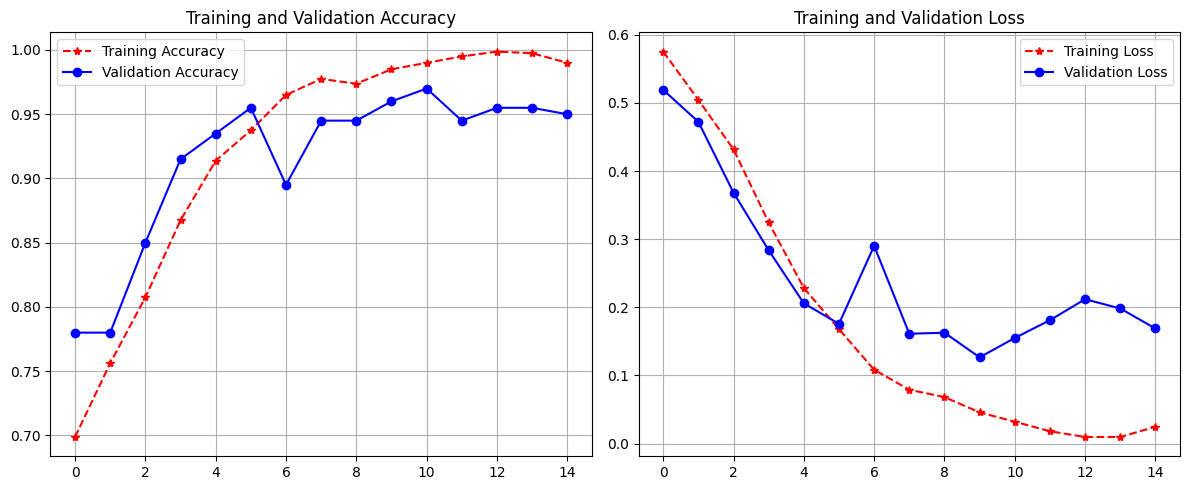

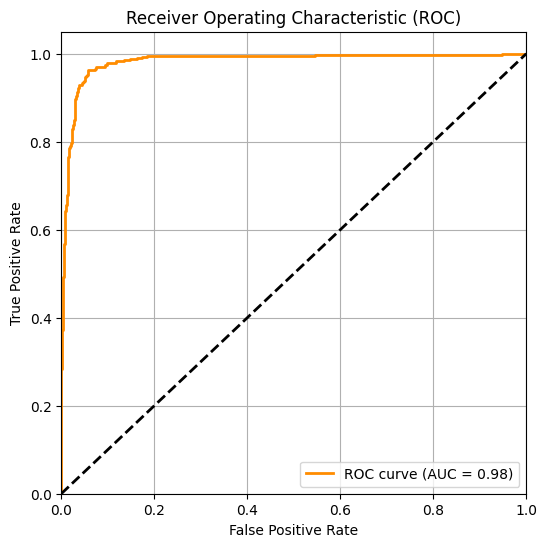

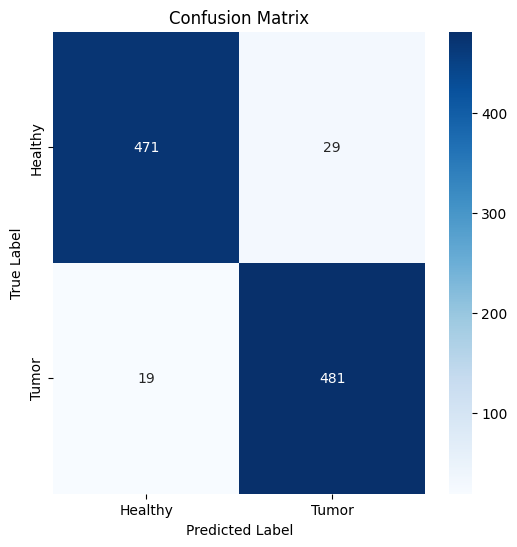

In [61]:
import os
import numpy as np
import random
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
real_healthy_dir = '/kaggle/input/brain-tumor-detection/no'
real_tumor_dir = '/kaggle/input/brain-tumor-detection/yes'

gan_healthy_dir = '/kaggle/input/healthy-gan'
gan_tumor_dir = '/kaggle/input/tumour-gan'

test_data_dir = '/kaggle/input/test-dataset'

# Working directories
combined_train_dir = '/kaggle/working/combined_train'
combined_val_dir = '/kaggle/working/combined_val'

os.makedirs(combined_train_dir, exist_ok=True)
os.makedirs(combined_val_dir, exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'tumour'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'tumour'), exist_ok=True)

# Helper function to copy N files from src to dst
def copy_n_files(src, dst, n=100):
    files = os.listdir(src)
    selected = random.sample(files, min(n, len(files)))
    for fname in selected:
        copyfile(os.path.join(src, fname), os.path.join(dst, fname))

# Clear previous data
for path in [combined_train_dir, combined_val_dir]:
    for cls in ['healthy', 'tumour']:
        folder = os.path.join(path, cls)
        if os.path.exists(folder):
            import shutil
            shutil.rmtree(folder)
        os.makedirs(folder)

# Copy training images
copy_n_files(real_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 360)
copy_n_files(real_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 360)

copy_n_files(gan_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 40)
copy_n_files(gan_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 40)

# Copy validation images
copy_n_files(real_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 90)
copy_n_files(real_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 90)

copy_n_files(gan_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 10)
copy_n_files(gan_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 10)

# Data generators
img_size = (128, 128)
batch_size = 32

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    combined_train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

val_generator = datagen_val.flow_from_directory(
    combined_val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

test_generator = datagen_test.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Build CNN model (same as before)
def build_cnn_model():
    return Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

model = build_cnn_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

# Evaluate on test set
test_generator.reset()
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int)
y_true = test_generator.classes
y_scores = preds.flatten()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Plot Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '*--', color='red', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'o-', color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, '*--', color='red', label='Training Loss')
plt.plot(epochs_range, val_loss, 'o-', color='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curve.png')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('/kaggle/working/roc_curve.png')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Healthy', 'Tumor']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# 200 GAN and 800 Real

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.6539 - loss: 0.5998 - val_accuracy: 0.7500 - val_loss: 0.5015
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7861 - loss: 0.4849 - val_accuracy: 0.8150 - val_loss: 0.4173
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8272 - loss: 0.3770 - val_accuracy: 0.8800 - val_loss: 0.3105
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8884 - loss: 0.2891 - val_accuracy: 0.9050 - val_loss: 0.2583
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9225 - loss: 0.2337 - val_accuracy: 0.9400 - val_loss: 0.1624
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9482 - loss: 0.1458 - val_accuracy: 0.9450 - val_loss: 0.1262
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9536 - loss: 0.1156 - val_accuracy: 0.9650 - val_loss: 0.0732
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9910 - loss: 0.0508 - val_accuracy: 0.9700 - val_loss: 0.

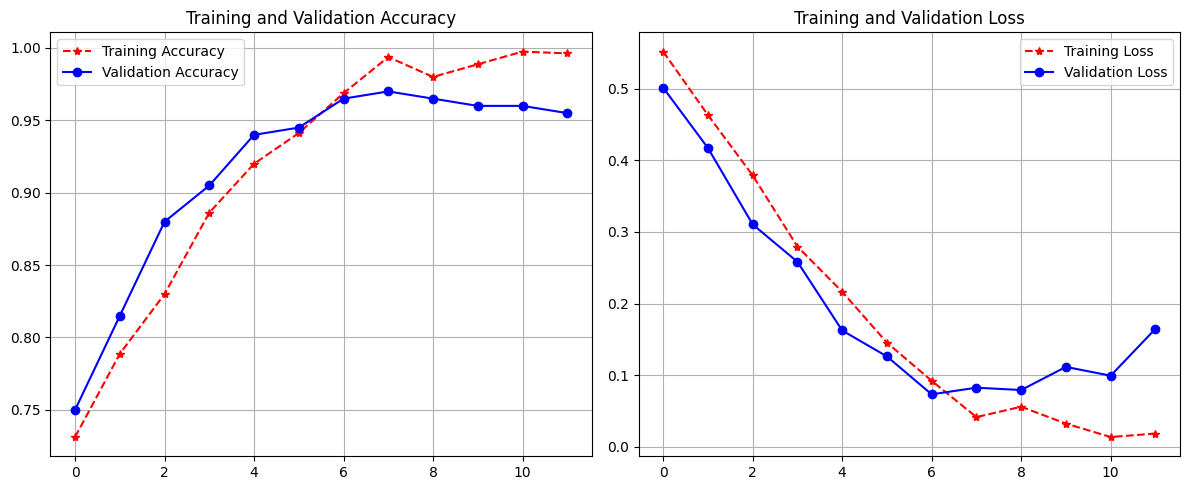

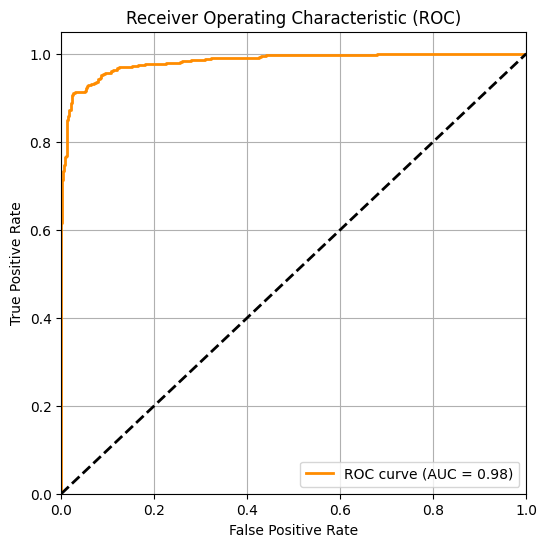

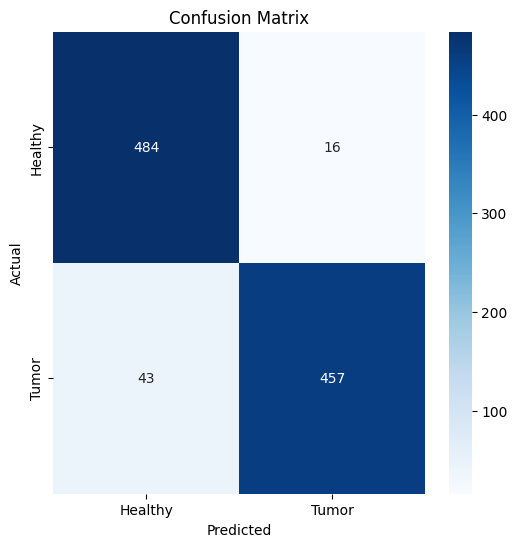

In [35]:
import os
import numpy as np
import random
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
real_healthy_dir = '/kaggle/input/brain-tumor-detection/no'
real_tumor_dir = '/kaggle/input/brain-tumor-detection/yes'

gan_healthy_dir = '/kaggle/input/healthy-gan'
gan_tumor_dir = '/kaggle/input/tumour-gan'

test_data_dir = '/kaggle/input/test-dataset'

# Working directories
combined_train_dir = '/kaggle/working/combined_train'
combined_val_dir = '/kaggle/working/combined_val'

os.makedirs(combined_train_dir, exist_ok=True)
os.makedirs(combined_val_dir, exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'tumour'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'tumour'), exist_ok=True)

# Helper function to copy N files from src to dst
def copy_n_files(src, dst, n=100):
    files = os.listdir(src)
    selected = random.sample(files, min(n, len(files)))
    for fname in selected:
        copyfile(os.path.join(src, fname), os.path.join(dst, fname))

# Clear previous data
for path in [combined_train_dir, combined_val_dir]:
    for cls in ['healthy', 'tumour']:
        folder = os.path.join(path, cls)
        if os.path.exists(folder):
            import shutil
            shutil.rmtree(folder)
        os.makedirs(folder)

# Copy training images
copy_n_files(real_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 320)
copy_n_files(real_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 320)

copy_n_files(gan_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 80)
copy_n_files(gan_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 80)

# Copy validation images
copy_n_files(real_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 80)
copy_n_files(real_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 80)

copy_n_files(gan_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 20)
copy_n_files(gan_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 20)

# Data generators
img_size = (128, 128)
batch_size = 32

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    combined_train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

val_generator = datagen_val.flow_from_directory(
    combined_val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

test_generator = datagen_test.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Build CNN model
def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_cnn_model()

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

# Evaluate on test set
test_generator.reset()
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int)
y_true = test_generator.classes
y_scores = preds.flatten()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Plot Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '*--', color='red', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'o-', color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, '*--', color='red', label='Training Loss')
plt.plot(epochs_range, val_loss, 'o-', color='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curve.png')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('/kaggle/working/roc_curve.png')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Healthy', 'Tumor']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# 300 GAN and 700 Real

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.6561 - loss: 0.6675 - val_accuracy: 0.7400 - val_loss: 0.4854
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7748 - loss: 0.4687 - val_accuracy: 0.8100 - val_loss: 0.4210
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8268 - loss: 0.3772 - val_accuracy: 0.8100 - val_loss: 0.4324
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8802 - loss: 0.3081 - val_accuracy: 0.9050 - val_loss: 0.2871
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8984 - loss: 0.2629 - val_accuracy: 0.9150 - val_loss: 0.2524
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9197 - loss: 0.2057 - val_accuracy: 0.9050 - val_loss: 0.2075
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9482 - loss: 0.1273 - val_accuracy: 0.9200 - val_loss: 0.1778
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9662 - loss: 0.0882 - val_accuracy: 0.9250 - val_loss: 0.

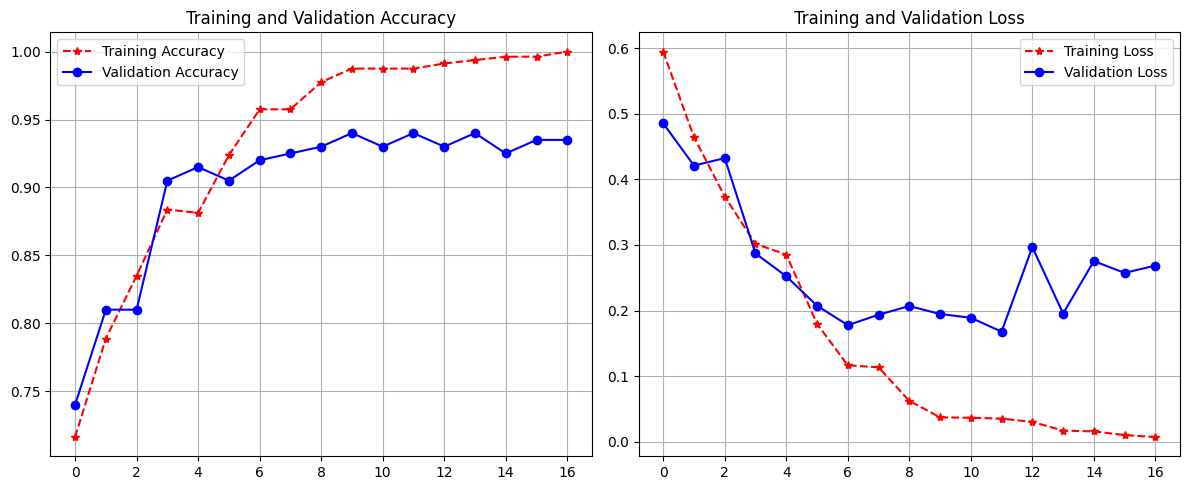

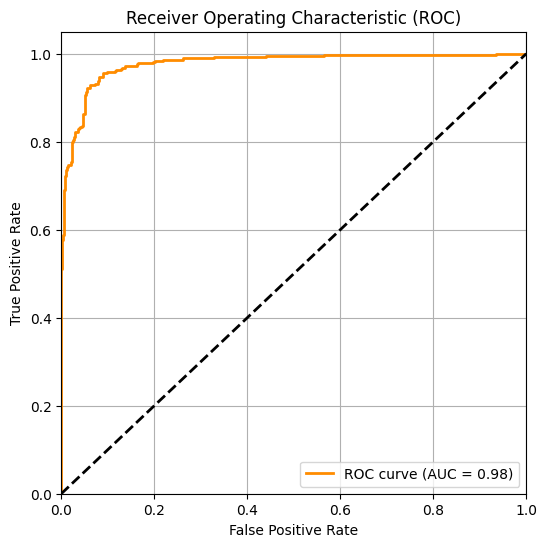

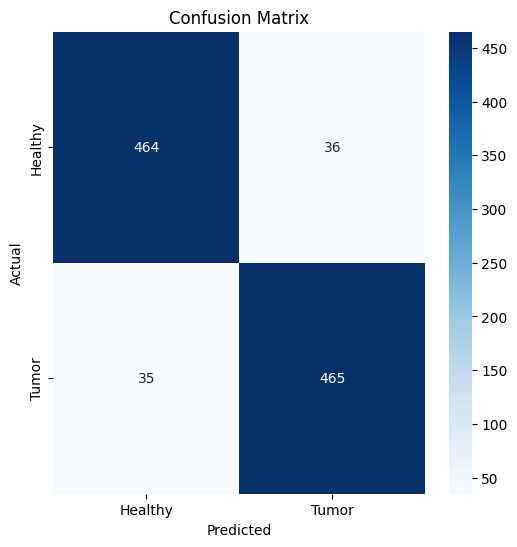

In [39]:
import os
import numpy as np
import random
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
real_healthy_dir = '/kaggle/input/brain-tumor-detection/no'
real_tumor_dir = '/kaggle/input/brain-tumor-detection/yes'

gan_healthy_dir = '/kaggle/input/healthy-gan'
gan_tumor_dir = '/kaggle/input/tumour-gan'

test_data_dir = '/kaggle/input/test-dataset'

# Working directories
combined_train_dir = '/kaggle/working/combined_train'
combined_val_dir = '/kaggle/working/combined_val'

os.makedirs(combined_train_dir, exist_ok=True)
os.makedirs(combined_val_dir, exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'tumour'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'tumour'), exist_ok=True)

# Helper function to copy N files from src to dst
def copy_n_files(src, dst, n=100):
    files = os.listdir(src)
    selected = random.sample(files, min(n, len(files)))
    for fname in selected:
        copyfile(os.path.join(src, fname), os.path.join(dst, fname))

# Clear previous data
for path in [combined_train_dir, combined_val_dir]:
    for cls in ['healthy', 'tumour']:
        folder = os.path.join(path, cls)
        if os.path.exists(folder):
            import shutil
            shutil.rmtree(folder)
        os.makedirs(folder)

# Copy training images
copy_n_files(real_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 280)
copy_n_files(real_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 280)

copy_n_files(gan_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 120)
copy_n_files(gan_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 120)

# Copy validation images
copy_n_files(real_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 70)
copy_n_files(real_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 70)

copy_n_files(gan_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 30)
copy_n_files(gan_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 30)

# Data generators
img_size = (128, 128)
batch_size = 32

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    combined_train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

val_generator = datagen_val.flow_from_directory(
    combined_val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

test_generator = datagen_test.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Build CNN model (same as before)
def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_cnn_model()

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

# Evaluate on test set
test_generator.reset()
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int)
y_true = test_generator.classes
y_scores = preds.flatten()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Plot Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '*--', color='red', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'o-', color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, '*--', color='red', label='Training Loss')
plt.plot(epochs_range, val_loss, 'o-', color='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curve.png')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('/kaggle/working/roc_curve.png')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Healthy', 'Tumor']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# 

# 400 GAN and 600 Real

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.6459 - loss: 0.6845 - val_accuracy: 0.7800 - val_loss: 0.5167
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7909 - loss: 0.4761 - val_accuracy: 0.8500 - val_loss: 0.3735
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8639 - loss: 0.3521 - val_accuracy: 0.8800 - val_loss: 0.3168
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8900 - loss: 0.2753 - val_accuracy: 0.9100 - val_loss: 0.2089
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9436 - loss: 0.1521 - val_accuracy: 0.9400 - val_loss: 0.2072
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9670 - loss: 0.1110 - val_accuracy: 0.9400 - val_loss: 0.1975
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9686 - loss: 0.0828 - val_accuracy: 0.9400 - val_loss: 0.1978
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9783 - loss: 0.0639 - val_accuracy: 0.9250 - val_loss: 0.

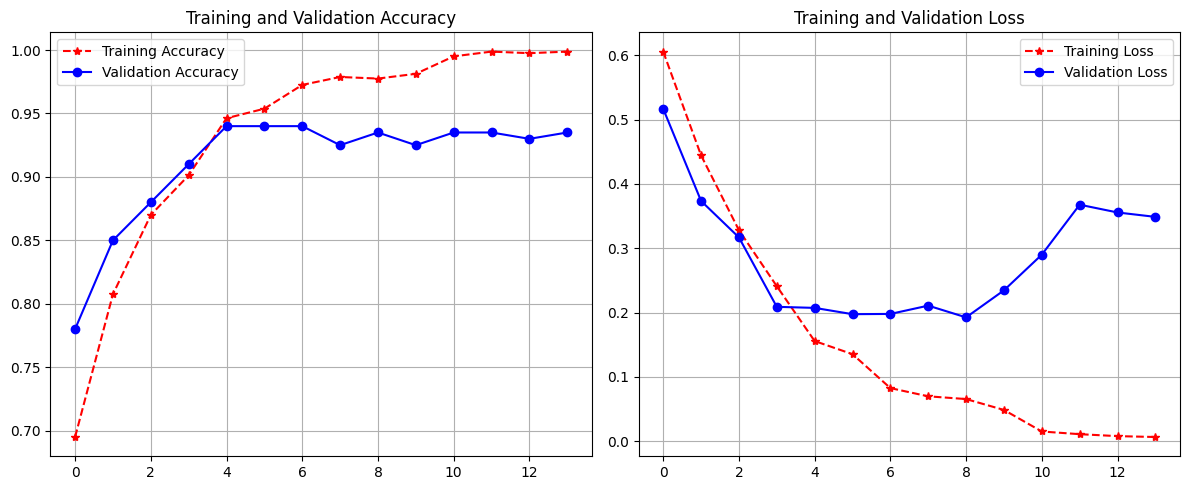

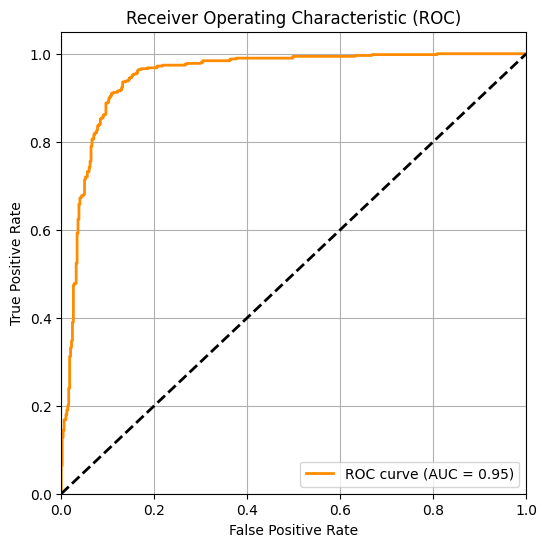

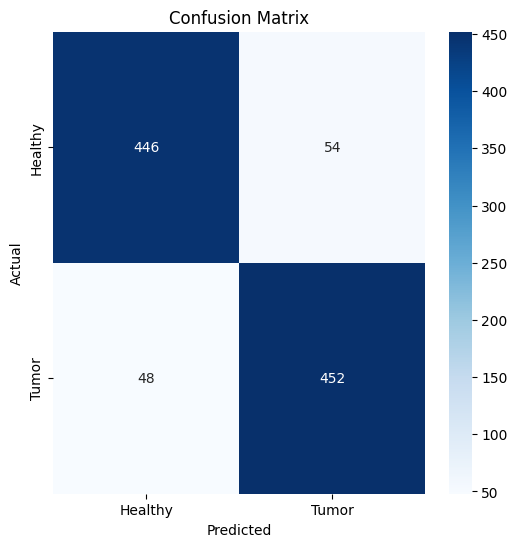

In [45]:
import os
import numpy as np
import random
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
real_healthy_dir = '/kaggle/input/brain-tumor-detection/no'
real_tumor_dir = '/kaggle/input/brain-tumor-detection/yes'

gan_healthy_dir = '/kaggle/input/healthy-gan'
gan_tumor_dir = '/kaggle/input/tumour-gan'

test_data_dir = '/kaggle/input/test-dataset'

# Working directories
combined_train_dir = '/kaggle/working/combined_train'
combined_val_dir = '/kaggle/working/combined_val'

os.makedirs(combined_train_dir, exist_ok=True)
os.makedirs(combined_val_dir, exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'tumour'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'tumour'), exist_ok=True)

# Helper function to copy N files from src to dst
def copy_n_files(src, dst, n=100):
    files = os.listdir(src)
    selected = random.sample(files, min(n, len(files)))
    for fname in selected:
        copyfile(os.path.join(src, fname), os.path.join(dst, fname))

# Clear previous data
for path in [combined_train_dir, combined_val_dir]:
    for cls in ['healthy', 'tumour']:
        folder = os.path.join(path, cls)
        if os.path.exists(folder):
            import shutil
            shutil.rmtree(folder)
        os.makedirs(folder)

# Copy training images
copy_n_files(real_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 240)
copy_n_files(real_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 240)

copy_n_files(gan_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 160)
copy_n_files(gan_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 160)

# Copy validation images
copy_n_files(real_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 60)
copy_n_files(real_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 60)

copy_n_files(gan_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 40)
copy_n_files(gan_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 40)

# Data generators
img_size = (128, 128)
batch_size = 32

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    combined_train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

val_generator = datagen_val.flow_from_directory(
    combined_val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

test_generator = datagen_test.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Build CNN model (same as before)
def build_cnn_model():
    return Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

model = build_cnn_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

# Evaluate on test set
test_generator.reset()
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int)
y_true = test_generator.classes
y_scores = preds.flatten()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Plot Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '*--', color='red', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'o-', color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, '*--', color='red', label='Training Loss')
plt.plot(epochs_range, val_loss, 'o-', color='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curve.png')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('/kaggle/working/roc_curve.png')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Healthy', 'Tumor']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# 600 GAN and 400 Real

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.6773 - loss: 0.6601 - val_accuracy: 0.8450 - val_loss: 0.3430
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8831 - loss: 0.3255 - val_accuracy: 0.9200 - val_loss: 0.1874
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9213 - loss: 0.2492 - val_accuracy: 0.9550 - val_loss: 0.1500
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9434 - loss: 0.1504 - val_accuracy: 0.9350 - val_loss: 0.1559
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9583 - loss: 0.1042 - val_accuracy: 0.9500 - val_loss: 0.1341
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9800 - loss: 0.0553 - val_accuracy: 0.9300 - val_loss: 0.1777
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9707 - loss: 0.0891 - val_accuracy: 0.9600 - val_loss: 0.1231
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9857 - loss: 0.0324 - val_accuracy: 0.9450 - val_loss: 0.

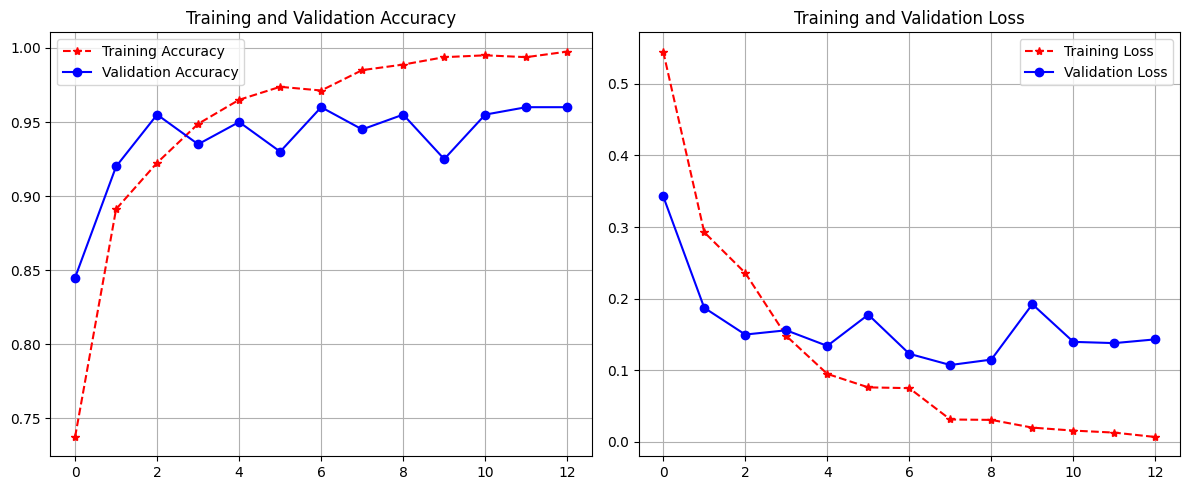

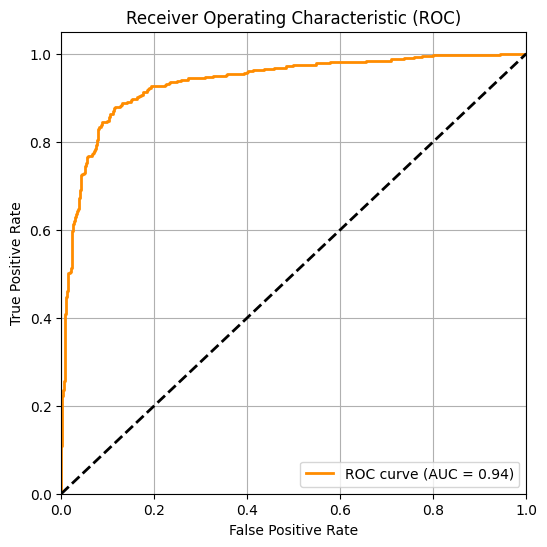

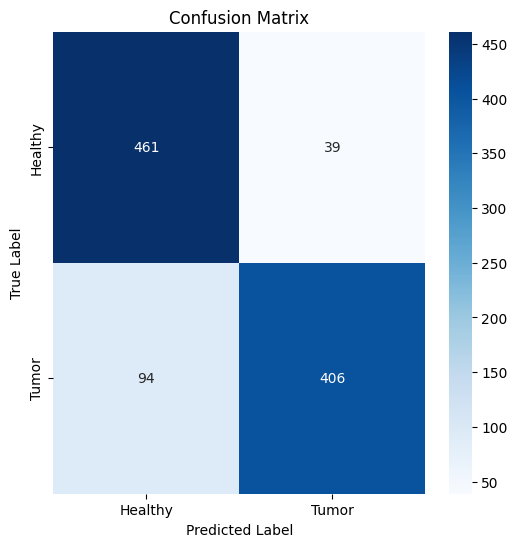

In [47]:
import os
import numpy as np
import random
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
real_healthy_dir = '/kaggle/input/brain-tumor-detection/no'
real_tumor_dir = '/kaggle/input/brain-tumor-detection/yes'

gan_healthy_dir = '/kaggle/input/healthy-gan'
gan_tumor_dir = '/kaggle/input/tumour-gan'

test_data_dir = '/kaggle/input/test-dataset'

# Working directories
combined_train_dir = '/kaggle/working/combined_train'
combined_val_dir = '/kaggle/working/combined_val'

os.makedirs(combined_train_dir, exist_ok=True)
os.makedirs(combined_val_dir, exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'tumour'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'tumour'), exist_ok=True)

# Helper function to copy N files from src to dst
def copy_n_files(src, dst, n=100):
    files = os.listdir(src)
    selected = random.sample(files, min(n, len(files)))
    for fname in selected:
        copyfile(os.path.join(src, fname), os.path.join(dst, fname))

# Clear previous data
for path in [combined_train_dir, combined_val_dir]:
    for cls in ['healthy', 'tumour']:
        folder = os.path.join(path, cls)
        if os.path.exists(folder):
            import shutil
            shutil.rmtree(folder)
        os.makedirs(folder)

# Copy training images
copy_n_files(real_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 160)
copy_n_files(real_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 160)

copy_n_files(gan_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 240)
copy_n_files(gan_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 240)

# Copy validation images
copy_n_files(real_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 40)
copy_n_files(real_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 40)

copy_n_files(gan_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 60)
copy_n_files(gan_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 60)

# Data generators
img_size = (128, 128)
batch_size = 32

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    combined_train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

val_generator = datagen_val.flow_from_directory(
    combined_val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

test_generator = datagen_test.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Build CNN model (same as before)
def build_cnn_model():
    return Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

model = build_cnn_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

# Evaluate on test set
test_generator.reset()
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int)
y_true = test_generator.classes
y_scores = preds.flatten()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Plot Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '*--', color='red', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'o-', color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, '*--', color='red', label='Training Loss')
plt.plot(epochs_range, val_loss, 'o-', color='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curve.png')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('/kaggle/working/roc_curve.png')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Healthy', 'Tumor']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# 700 GAN and 300 Real

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.6968 - loss: 0.5800 - val_accuracy: 0.9050 - val_loss: 0.3373
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9334 - loss: 0.2120 - val_accuracy: 0.9450 - val_loss: 0.2155
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9483 - loss: 0.1557 - val_accuracy: 0.9350 - val_loss: 0.1406
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9787 - loss: 0.0669 - val_accuracy: 0.9450 - val_loss: 0.1655
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9773 - loss: 0.0780 - val_accuracy: 0.9350 - val_loss: 0.1682
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9890 - loss: 0.0476 - val_accuracy: 0.9350 - val_loss: 0.1379
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9800 - loss: 0.0478 - val_accuracy: 0.9500 - val_loss: 0.2030
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9863 - loss: 0.0707 - val_accuracy: 0.9400 - val_loss: 0.

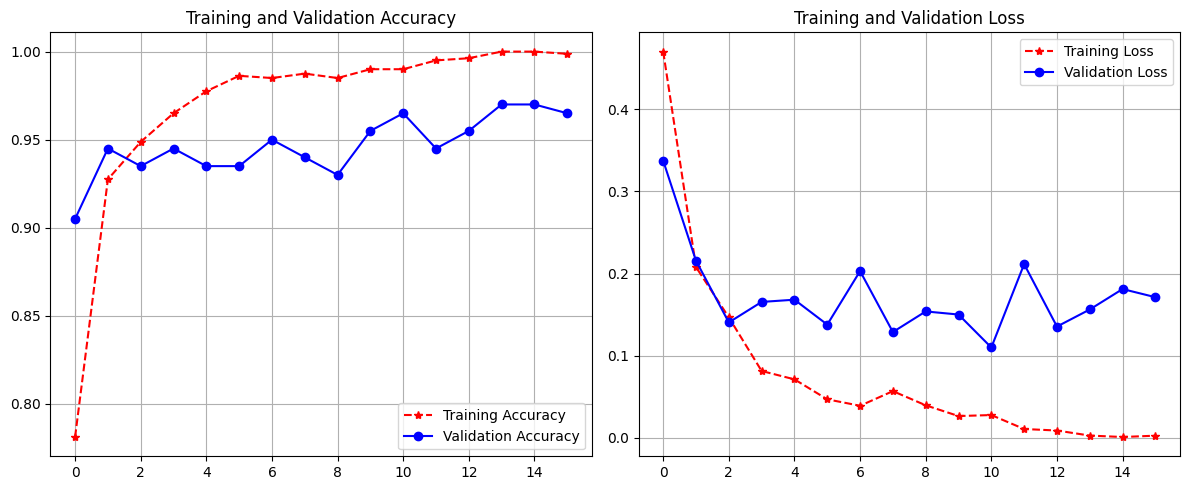

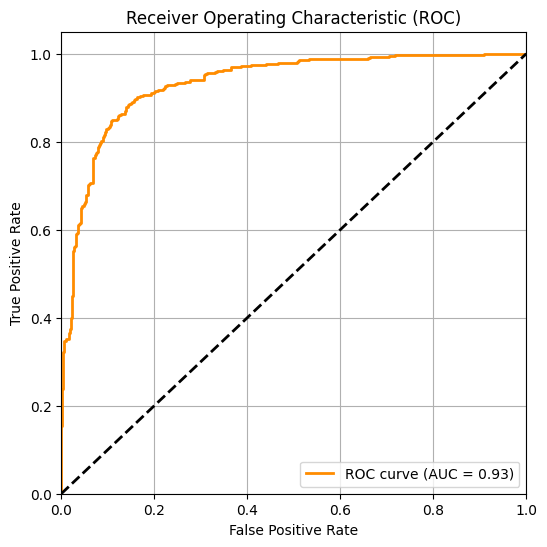

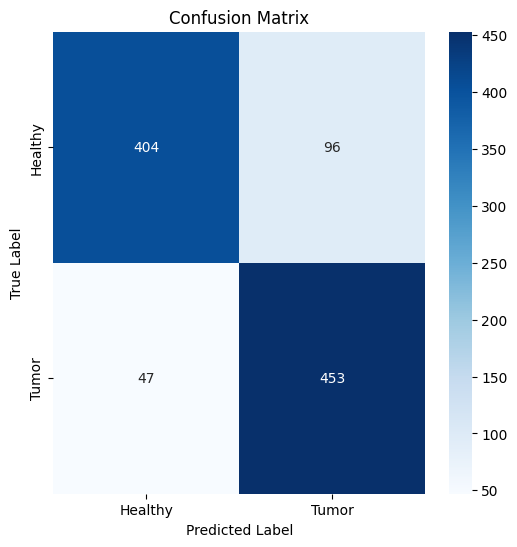

In [49]:
import os
import numpy as np
import random
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
real_healthy_dir = '/kaggle/input/brain-tumor-detection/no'
real_tumor_dir = '/kaggle/input/brain-tumor-detection/yes'

gan_healthy_dir = '/kaggle/input/healthy-gan'
gan_tumor_dir = '/kaggle/input/tumour-gan'

test_data_dir = '/kaggle/input/test-dataset'

# Working directories
combined_train_dir = '/kaggle/working/combined_train'
combined_val_dir = '/kaggle/working/combined_val'

os.makedirs(combined_train_dir, exist_ok=True)
os.makedirs(combined_val_dir, exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'tumour'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'tumour'), exist_ok=True)

# Helper function to copy N files from src to dst
def copy_n_files(src, dst, n=100):
    files = os.listdir(src)
    selected = random.sample(files, min(n, len(files)))
    for fname in selected:
        copyfile(os.path.join(src, fname), os.path.join(dst, fname))

# Clear previous data
for path in [combined_train_dir, combined_val_dir]:
    for cls in ['healthy', 'tumour']:
        folder = os.path.join(path, cls)
        if os.path.exists(folder):
            import shutil
            shutil.rmtree(folder)
        os.makedirs(folder)

# Copy training images
copy_n_files(real_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 120)
copy_n_files(real_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 120)

copy_n_files(gan_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 280)
copy_n_files(gan_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 280)

# Copy validation images
copy_n_files(real_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 30)
copy_n_files(real_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 30)

copy_n_files(gan_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 70)
copy_n_files(gan_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 70)

# Data generators
img_size = (128, 128)
batch_size = 32

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    combined_train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

val_generator = datagen_val.flow_from_directory(
    combined_val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

test_generator = datagen_test.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Build CNN model (same as before)
def build_cnn_model():
    return Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

model = build_cnn_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

# Evaluate on test set
test_generator.reset()
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int)
y_true = test_generator.classes
y_scores = preds.flatten()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Plot Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '*--', color='red', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'o-', color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, '*--', color='red', label='Training Loss')
plt.plot(epochs_range, val_loss, 'o-', color='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curve.png')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('/kaggle/working/roc_curve.png')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Healthy', 'Tumor']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# 800 GAN and 200 Real

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.6236 - loss: 0.6844 - val_accuracy: 0.8900 - val_loss: 0.2349
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9294 - loss: 0.2159 - val_accuracy: 0.9800 - val_loss: 0.0944
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9660 - loss: 0.1127 - val_accuracy: 0.9650 - val_loss: 0.0861
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9712 - loss: 0.0754 - val_accuracy: 0.9750 - val_loss: 0.0614
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9794 - loss: 0.0560 - val_accuracy: 0.9900 - val_loss: 0.0456
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9776 - loss: 0.0538 - val_accuracy: 0.9700 - val_loss: 0.0536
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9974 - loss: 0.0147 - val_accuracy: 0.9700 - val_loss: 0.0713
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9947 - loss: 0.0172 - val_accuracy: 0.9750 - val_loss: 0.

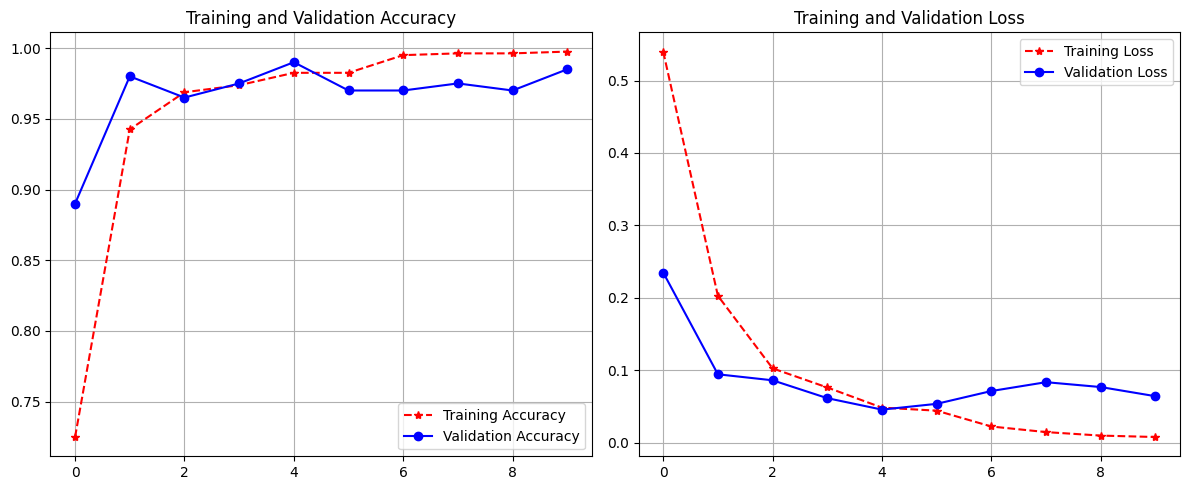

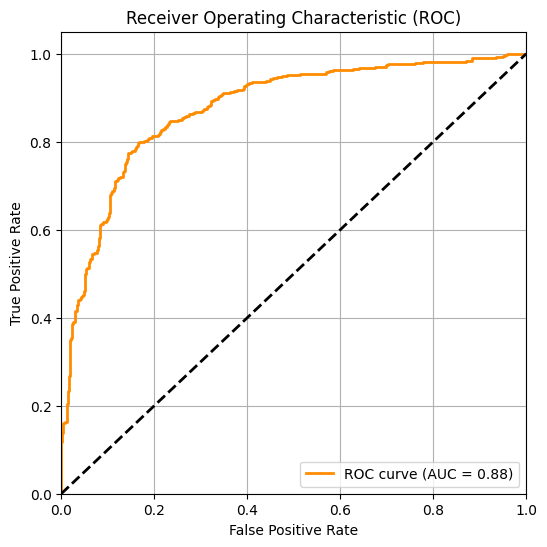

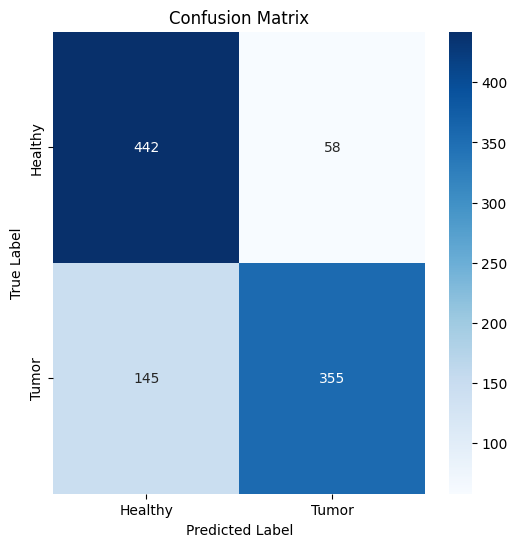

In [51]:
import os
import numpy as np
import random
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
real_healthy_dir = '/kaggle/input/brain-tumor-detection/no'
real_tumor_dir = '/kaggle/input/brain-tumor-detection/yes'

gan_healthy_dir = '/kaggle/input/healthy-gan'
gan_tumor_dir = '/kaggle/input/tumour-gan'

test_data_dir = '/kaggle/input/test-dataset'

# Working directories
combined_train_dir = '/kaggle/working/combined_train'
combined_val_dir = '/kaggle/working/combined_val'

os.makedirs(combined_train_dir, exist_ok=True)
os.makedirs(combined_val_dir, exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'tumour'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'tumour'), exist_ok=True)

# Helper function to copy N files from src to dst
def copy_n_files(src, dst, n=100):
    files = os.listdir(src)
    selected = random.sample(files, min(n, len(files)))
    for fname in selected:
        copyfile(os.path.join(src, fname), os.path.join(dst, fname))

# Clear previous data
for path in [combined_train_dir, combined_val_dir]:
    for cls in ['healthy', 'tumour']:
        folder = os.path.join(path, cls)
        if os.path.exists(folder):
            import shutil
            shutil.rmtree(folder)
        os.makedirs(folder)

# Copy training images
copy_n_files(real_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 80)
copy_n_files(real_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 80)

copy_n_files(gan_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 320)
copy_n_files(gan_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 320)

# Copy validation images
copy_n_files(real_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 20)
copy_n_files(real_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 20)

copy_n_files(gan_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 80)
copy_n_files(gan_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 80)

# Data generators
img_size = (128, 128)
batch_size = 32

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    combined_train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

val_generator = datagen_val.flow_from_directory(
    combined_val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

test_generator = datagen_test.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Build CNN model (same as before)
def build_cnn_model():
    return Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

model = build_cnn_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

# Evaluate on test set
test_generator.reset()
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int)
y_true = test_generator.classes
y_scores = preds.flatten()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Plot Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '*--', color='red', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'o-', color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, '*--', color='red', label='Training Loss')
plt.plot(epochs_range, val_loss, 'o-', color='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curve.png')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('/kaggle/working/roc_curve.png')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Healthy', 'Tumor']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# 900 GAN and 100 Real

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.6774 - loss: 0.6264 - val_accuracy: 0.9750 - val_loss: 0.1681
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9606 - loss: 0.1582 - val_accuracy: 0.9750 - val_loss: 0.0804
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9741 - loss: 0.0922 - val_accuracy: 0.9750 - val_loss: 0.0562
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9850 - loss: 0.0534 - val_accuracy: 0.9750 - val_loss: 0.0547
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9867 - loss: 0.0356 - val_accuracy: 0.9800 - val_loss: 0.0779
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9907 - loss: 0.0283 - val_accuracy: 0.9750 - val_loss: 0.0903
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9915 - loss: 0.0519 - val_accuracy: 0.9700 - val_loss: 0.0768
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9947 - loss: 0.0218 - val_accuracy: 0.9750 - val_loss: 0.

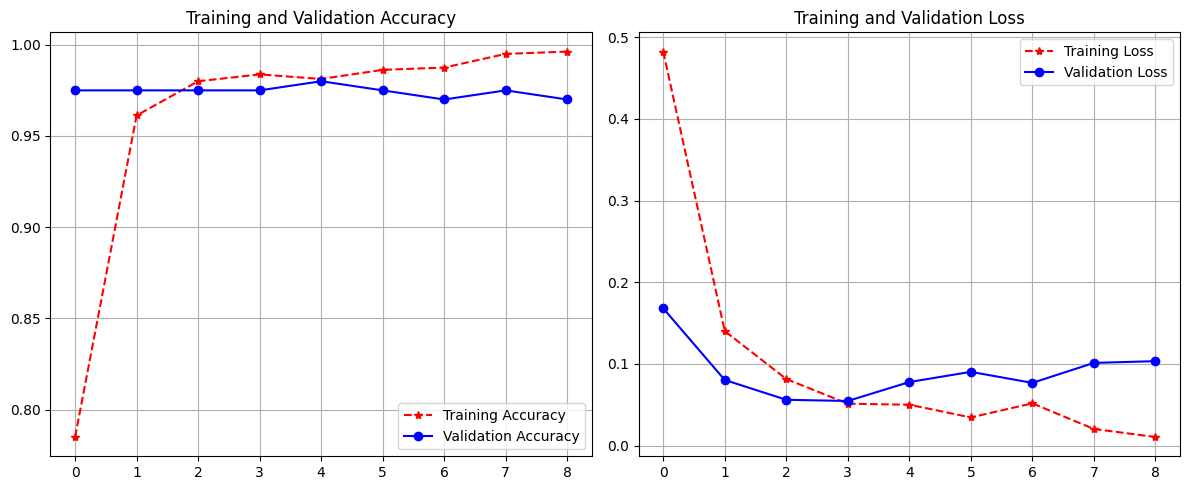

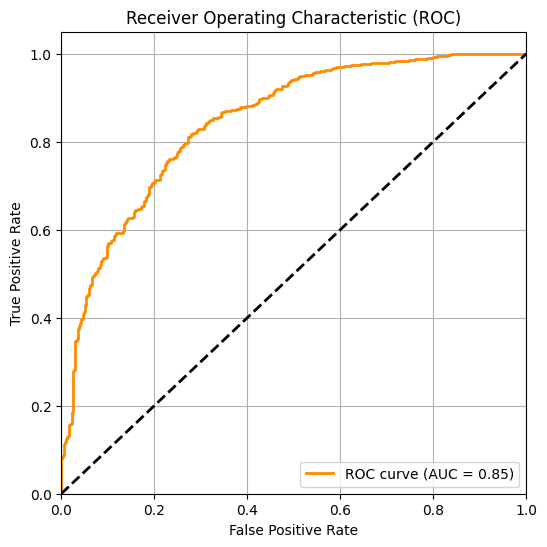

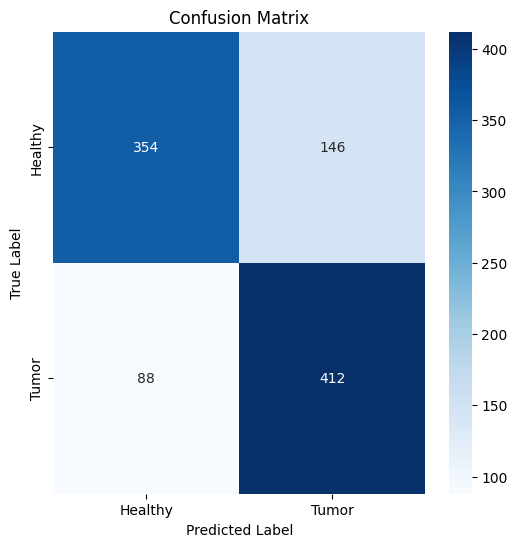

In [55]:
import os
import numpy as np
import random
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
real_healthy_dir = '/kaggle/input/brain-tumor-detection/no'
real_tumor_dir = '/kaggle/input/brain-tumor-detection/yes'

gan_healthy_dir = '/kaggle/input/healthy-gan'
gan_tumor_dir = '/kaggle/input/tumour-gan'

test_data_dir = '/kaggle/input/test-dataset'

# Working directories
combined_train_dir = '/kaggle/working/combined_train'
combined_val_dir = '/kaggle/working/combined_val'

os.makedirs(combined_train_dir, exist_ok=True)
os.makedirs(combined_val_dir, exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'tumour'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_val_dir, 'tumour'), exist_ok=True)

# Helper function to copy N files from src to dst
def copy_n_files(src, dst, n=100):
    files = os.listdir(src)
    selected = random.sample(files, min(n, len(files)))
    for fname in selected:
        copyfile(os.path.join(src, fname), os.path.join(dst, fname))

# Clear previous data
for path in [combined_train_dir, combined_val_dir]:
    for cls in ['healthy', 'tumour']:
        folder = os.path.join(path, cls)
        if os.path.exists(folder):
            import shutil
            shutil.rmtree(folder)
        os.makedirs(folder)

# Copy training images
copy_n_files(real_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 40)
copy_n_files(real_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 40)

copy_n_files(gan_healthy_dir, os.path.join(combined_train_dir, 'healthy'), 360)
copy_n_files(gan_tumor_dir, os.path.join(combined_train_dir, 'tumour'), 360)

# Copy validation images
copy_n_files(real_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 10)
copy_n_files(real_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 10)

copy_n_files(gan_healthy_dir, os.path.join(combined_val_dir, 'healthy'), 90)
copy_n_files(gan_tumor_dir, os.path.join(combined_val_dir, 'tumour'), 90)

# Data generators
img_size = (128, 128)
batch_size = 32

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    combined_train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

val_generator = datagen_val.flow_from_directory(
    combined_val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

test_generator = datagen_test.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Build CNN model (same as before)
def build_cnn_model():
    return Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

model = build_cnn_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

# Evaluate on test set
test_generator.reset()
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int)
y_true = test_generator.classes
y_scores = preds.flatten()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Plot Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '*--', color='red', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'o-', color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, '*--', color='red', label='Training Loss')
plt.plot(epochs_range, val_loss, 'o-', color='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curve.png')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('/kaggle/working/roc_curve.png')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Healthy', 'Tumor']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()